In [26]:
import os, csv
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras import layers, Input
from keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import csv
import os,random

from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM
from keras.layers.convolutional import Convolution1D
from keras.layers.core import Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import *
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

import datetime
now = datetime.datetime.now

In [2]:
def process(temp):
    min_len = 3000
    for i in range(11):
        j = 0
        while temp[j][i] != '' and j<len(temp)-1:
            j+=1
        min_len = min(min_len, j);
#     print(min_len)
    return temp[:min_len]

In [8]:
types = {'B_ID':8, 'E_ID':16, 'NE_ID':27, 'S_ID':10, 'P_ID':16}
x_val = []
x_id = []
for ids, vals in types.items():
    for i in range(1,vals+1):
        x_id.append(ids + str(i))
        try: 
            with open("../po-cf-ex-1-features/"+ids+str(i)+".csv", 'r') as f:
                temp = list(csv.reader(f, delimiter = ","))
            temp = process(temp)
            temp = np.asarray(temp)
            temp = temp.astype(np.float64)
        except:
            print("Problem in:", ids, i)
        x_val.append(temp.tolist())
x_val = np.asarray(sequence.pad_sequences(x_val, maxlen=600)).astype(np.float64)
print("x_val shape:", x_val.shape)

Problem in: E_ID 8
x_val shape: (77, 600, 11)


In [11]:
po_val = []
cf_val = []
for ids in x_id:
    try:
        df = pd.read_excel("../KiMoRe/"+ids+"/Es1/Label/ClinicalAssessment_"+ids+".xlsx")
    except:
        print("problem in: ", ids)
    df = np.array(df).reshape((16,))
    po_val.append(df[6])
    cf_val.append(df[11])
po_val = np.asarray(po_val).astype(np.float64)
cf_val = np.asarray(cf_val).astype(np.float64)
ts_val = po_val+cf_val
print("shape of CF: ", cf_val.shape)
print("shape of PO: ", po_val.shape)
print("shape of TS: ", ts_val.shape)
# print(po_val)
for i in range(len(ts_val)):
    if np.isnan(ts_val[i]):
        print(i)
print(ts_val)


problem in:  E_ID8
shape of CF:  (77,)
shape of PO:  (77,)
shape of TS:  (77,)
[41.         38.         28.21008112 33.3397327  44.33333333 45.33333333
 40.33333333 44.33333333 48.33333333 49.33333333 42.66666667 44.66666667
 46.         46.66666667 50.         50.         50.         48.33333333
 50.         50.         46.33333333 44.         50.         47.
 39.66666667 41.         44.33333333 46.33333333 40.66666667 43.66666667
 42.         40.         42.         34.         46.         40.
 50.         50.         45.         47.         47.         38.
 50.         46.         46.         43.         41.         50.
 47.         49.         49.         27.         34.         44.
 26.         32.89508774 38.41075339 26.66666667 36.         26.33333333
 33.66666667 48.         27.         50.         14.         33.
 50.         22.         32.         40.         34.3081805  14.66666667
 35.66666667 36.66666667 36.         27.66666667 37.        ]


In [12]:
def jumble_up(val):
    return np.random.permutation(val)

In [14]:
indices = np.arange(len(ts_val))
indices = jumble_up(indices)
print(indices)
temp_x = x_val
temp_ts = ts_val
for i in range(len(ts_val)):
    x_val[i] = temp_x[indices[i]]
    ts_val[i] = temp_ts[indices[i]]

[69 19 72 25 39 21 50  8 37 32 13 34 36 62 53 35 43 24 14 55 18 47 60 68
 46 26 58  2 29 23 56 17 75 30 57 70 52 76 22 42 66 31 44 49 54  4  9 28
 40 33 74  1 11 65  7 59  0 15 45 12 41  3 63 27 71 73 67 10  6 48  5 16
 64 51 38 20 61]


In [16]:
x_val /= np.max(np.abs(x_val))
ts_val /= np.max(np.abs(ts_val))
x_train, x_test, y_train, y_test = train_test_split(x_val,ts_val, test_size=0.3)
print(y_train)

[0.81333333 0.71333333 0.86       0.72       0.28       0.72
 0.86       0.67333333 0.85333333 0.84       0.52666667 0.29333333
 0.82       0.92       0.94       0.68       0.8        0.28
 0.68       1.         0.65790175 0.67333333 1.         0.64
 0.71333333 0.54       0.53333333 0.86       1.         0.92
 0.67333333 0.86       0.74       1.         0.9        0.76821507
 0.8        0.74       0.52666667 1.         0.82       0.88
 0.28       0.86       0.52666667 0.87333333 0.72       0.67333333
 0.55333333 0.64       0.8        0.65790175 0.81333333]


In [17]:
timesteps = 600 
nr = 77   
n_dim = 11  
dropout_rate = 0.1

In [27]:
def Network():
    model = Sequential()

    model.add(Bidirectional(LSTM(100, recurrent_dropout = 0.5, return_sequences = True), input_shape = (timesteps,n_dim)))
    model.add(Dropout(0.2))

    model.add(Dense(30, activation = 'tanh'))
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(10, recurrent_dropout = 0.5)))
    model.add(Dropout(0.25))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam())
    
    # Early stopping if the validaton Loss does not decrease for 100 epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience = 100)

    t = now()
    history = model.fit(x_train, y_train, batch_size=5, epochs=500, verbose=1, 
                     validation_data=(x_test, y_test),
                     callbacks = [early_stopping])
    print('Training time: %s' % (now() - t))
    
    # Plot the results
    plt.figure(1)
    plt.subplot(221)
    plt.plot(history.history['loss'])
    plt.title('Training Loss')
    plt.subplot(222)
    plt.plot(history.history['val_loss'])
    plt.title('Validation Loss')
    plt.tight_layout()
    plt.show()
    
    # Plot the prediction of the CNN model for the training and validation sets
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)

    plt.figure(figsize = (8,8))
    plt.subplot(2,1,1)
    plt.plot(pred_train,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
    plt.plot(y_train,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
    plt.ylim([-0.1,1.1])
    plt.title('Training Set',fontsize=18)
    plt.xlabel('Sequence Number',fontsize=16)
    plt.ylabel('Quality Scale',fontsize=16)
    plt.legend(loc=3, prop={'size':14}) # loc:position
    plt.subplot(2,1,2)
    plt.plot(pred_test,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
    plt.plot(y_test,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
    plt.title('Testing Set',fontsize=18)
    plt.ylim([-0.1,1.1])
    plt.xlabel('Sequence Number',fontsize=16)
    plt.ylabel('Quality Score',fontsize=16)
    plt.legend(loc=3, prop={'size':14}) # loc:position
    plt.tight_layout()
#     plt.savefig('../../Results/CNN_Vicon_Scores.png', dpi=300)
    plt.show()
    
    
    # Calculate the cumulative deviation and rms deviation for the validation set
    test_dev = abs(np.squeeze(pred_test)-y_test)
    # Cumulative deviation
    mean_abs_dev = np.mean(test_dev)
    # RMS deviation
    rms_dev = sqrt(mean_squared_error(pred_test, y_test))
    print('Mean absolute deviation:', mean_abs_dev)
    print('RMS deviation:', rms_dev)
    
    return mean_abs_dev, rms_dev

Epoch 1/500
11/11 [==============================] - 19s 1s/step - loss: 0.6352 - val_loss: 0.5236
Epoch 2/500
11/11 [==============================] - 11s 978ms/step - loss: 0.5856 - val_loss: 0.5224
Epoch 3/500
11/11 [==============================] - 11s 981ms/step - loss: 0.5986 - val_loss: 0.4901
Epoch 4/500
11/11 [==============================] - 9s 854ms/step - loss: 0.5944 - val_loss: 0.4897
Epoch 5/500
11/11 [==============================] - 9s 792ms/step - loss: 0.5734 - val_loss: 0.4850
Epoch 6/500
11/11 [==============================] - 10s 938ms/step - loss: 0.5458 - val_loss: 0.4934
Epoch 7/500
11/11 [==============================] - 10s 946ms/step - loss: 0.5362 - val_loss: 0.4957
Epoch 8/500
11/11 [==============================] - 10s 956ms/step - loss: 0.6108 - val_loss: 0.4835
Epoch 9/500
11/11 [==============================] - 10s 924ms/step - loss: 0.5699 - val_loss: 0.4770
Epoch 10/500
11/11 [==============================] - 10s 893ms/step - loss: 0.5095 - v

11/11 [==============================] - 8s 762ms/step - loss: 0.5630 - val_loss: 0.4704
Epoch 82/500
11/11 [==============================] - 8s 766ms/step - loss: 0.5787 - val_loss: 0.4701
Epoch 83/500
11/11 [==============================] - 8s 765ms/step - loss: 0.5648 - val_loss: 0.4750
Epoch 84/500
11/11 [==============================] - 8s 757ms/step - loss: 0.5439 - val_loss: 0.4683
Epoch 85/500
11/11 [==============================] - 8s 766ms/step - loss: 0.5750 - val_loss: 0.4682
Epoch 86/500
11/11 [==============================] - 8s 768ms/step - loss: 0.5639 - val_loss: 0.4637
Epoch 87/500
11/11 [==============================] - 8s 753ms/step - loss: 0.5567 - val_loss: 0.4790
Epoch 88/500
11/11 [==============================] - 8s 751ms/step - loss: 0.5613 - val_loss: 0.4699
Epoch 89/500
11/11 [==============================] - 8s 763ms/step - loss: 0.5371 - val_loss: 0.4967
Epoch 90/500
11/11 [==============================] - 8s 748ms/step - loss: 0.5697 - val_loss: 

Epoch 161/500
11/11 [==============================] - 8s 747ms/step - loss: 0.5301 - val_loss: 0.4558
Epoch 162/500
11/11 [==============================] - 8s 773ms/step - loss: 0.5004 - val_loss: 0.4526
Epoch 163/500
11/11 [==============================] - 8s 754ms/step - loss: 0.5247 - val_loss: 0.4558
Epoch 164/500
11/11 [==============================] - 8s 749ms/step - loss: 0.5103 - val_loss: 0.4789
Epoch 165/500
11/11 [==============================] - 8s 766ms/step - loss: 0.5362 - val_loss: 0.4731
Epoch 166/500
11/11 [==============================] - 9s 781ms/step - loss: 0.5798 - val_loss: 0.4820
Epoch 167/500
11/11 [==============================] - 8s 772ms/step - loss: 0.5540 - val_loss: 0.4649
Epoch 168/500
11/11 [==============================] - 8s 756ms/step - loss: 0.5334 - val_loss: 0.4575
Epoch 169/500
11/11 [==============================] - 8s 768ms/step - loss: 0.5159 - val_loss: 0.4484
Epoch 170/500
11/11 [==============================] - 8s 769ms/step - lo

11/11 [==============================] - 8s 743ms/step - loss: 0.5439 - val_loss: 0.4573
Epoch 241/500
11/11 [==============================] - 8s 746ms/step - loss: 0.5367 - val_loss: 0.4552
Epoch 242/500
11/11 [==============================] - 8s 755ms/step - loss: 0.5053 - val_loss: 0.4563
Epoch 243/500
11/11 [==============================] - 8s 743ms/step - loss: 0.5604 - val_loss: 0.4507
Epoch 244/500
11/11 [==============================] - 8s 741ms/step - loss: 0.4902 - val_loss: 0.4535
Epoch 245/500
11/11 [==============================] - 8s 736ms/step - loss: 0.5042 - val_loss: 0.4526
Epoch 246/500
11/11 [==============================] - 8s 743ms/step - loss: 0.5193 - val_loss: 0.4525
Epoch 247/500
11/11 [==============================] - 8s 746ms/step - loss: 0.4921 - val_loss: 0.4503
Epoch 248/500
11/11 [==============================] - 8s 732ms/step - loss: 0.5335 - val_loss: 0.4500
Epoch 249/500
11/11 [==============================] - 8s 739ms/step - loss: 0.5305 - v

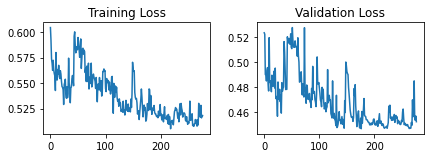

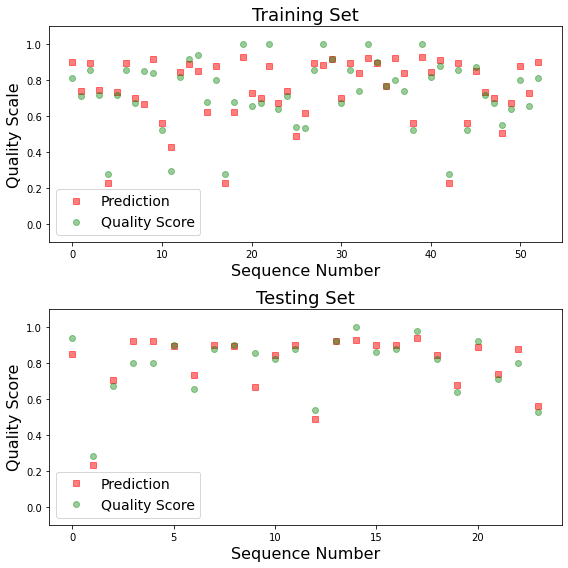

Mean absolute deviation: 0.050072104715721814
RMS deviation: 0.06620776977018526


In [28]:
Mean_abs_dev, RMS_dev  = Network()